# Discrete Unicycle Environment and Q-Learning Agent

## Introduction
This notebook defines a custom discrete grid-based environment for a unicycle agent and implements a Q-learning agent to learn navigation towards a goal while avoiding obstacles.


## Environment Class Definition
The `DiscreteUnicycleEnv` class defines a grid-based environment where the agent navigates to a goal while avoiding obstacles.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import deque
from matplotlib.patches import Rectangle, Arrow
from IPython.display import display, clear_output
import gym


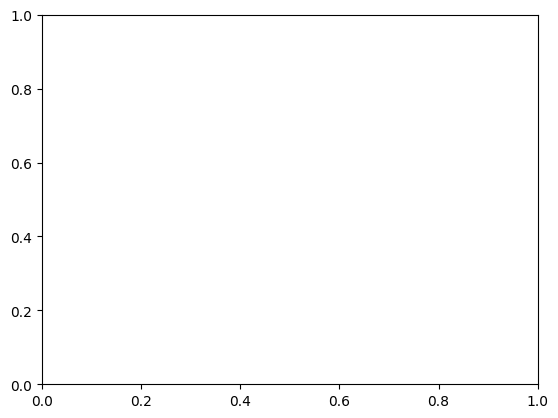

In [4]:

class DiscreteUnicycleEnv(gym.Env):
    def __init__(self, grid_size=10, obstacles=None):
        super(DiscreteUnicycleEnv, self).__init__()
        self.grid_size = grid_size
        self.max_x = grid_size
        self.max_y = grid_size

        self.action_space = gym.spaces.Discrete(8)  # 8 possible directions
        self.observation_space = gym.spaces.Dict({
            'state': gym.spaces.Box(low=0, high=grid_size, shape=(3,), dtype=np.int32),
            'obstacles': gym.spaces.Box(low=0, high=1, shape=(grid_size, grid_size), dtype=np.int32)
        })

        self.initial_state = np.array([0, 0, 0], dtype=np.int32)  # Initial state
        self.goal = np.array([grid_size - 1, grid_size - 1, 7])  # Goal state

        self.state = self.initial_state.copy()
        self.relative_state = self.get_relative_state()

        self.obstacles = np.zeros((grid_size, grid_size), dtype=np.int32)
        if obstacles:
            for obs in obstacles:
                self.obstacles[obs] = 1

        self.path = []
        self.fig, self.ax = plt.subplots()
        self.max_steps_per_episode = 50  # Maximum steps per episode

    def reset(self):
        self.state = self.initial_state.copy()  # Reset to initial state
        self.relative_state = self.get_relative_state()
        self.path = [self.state[:2].copy()]
        return {'state': self.state, 'obstacles': self.obstacles}
###############################################
    def step(self, action):
        x, y, theta = self.state
        if action == 0:  # Move right
            x += 1
        elif action == 1:  # Move up-right
            x += 1
            y += 1
        elif action == 2:  # Move up
            y += 1
        elif action == 3:  # Move up-left
            x -= 1
            y += 1
        elif action == 4:  # Move left
            x -= 1
        elif action == 5:  # Move down-left
            x -= 1
            y -= 1
        elif action == 6:  # Move down
            y -= 1
        elif action == 7:  # Move down-right
            x += 1
            y -= 1

        x = np.clip(x, 0, self.grid_size - 1)
        y = np.clip(y, 0, self.grid_size - 1)
        self.state = np.array([x, y, theta])

        self.relative_state = self.get_relative_state()
        self.path.append(self.state[:2].copy())

        done = self.is_done()
        reward = self.get_reward()

        return {'state': self.state, 'obstacles': self.obstacles}, reward, done, {}

    def get_relative_state(self):
        x, y, theta = self.state
        goal_x, goal_y, goal_theta = self.goal
        dx = goal_x - x
        dy = goal_y - y
        ex = (np.cos(theta * np.pi / 4) * dx + np.sin(theta * np.pi / 4) * dy) * 2
        ey = (-np.sin(theta * np.pi / 4) * dx + np.cos(theta * np.pi / 4) * dy) * 2
        ex = np.rint(ex)
        ey = np.rint(ey)
        etheta = (goal_theta - theta) % 8
        return np.array([ex, ey, etheta], dtype=np.int16)
###################################
    def get_reward(self):
        x, y, theta = self.state
        if self.obstacles[x, y] == 1:  # Collision with obstacle
            return -100
        distance = np.sqrt((x - self.goal[0])**2 + (y - self.goal[1])**2)
        reward = -distance
        if self.is_done():
            reward += 100
        else:
            reward -= 1  # Penalty for each step
        return reward
###################################
    def is_done(self):
        x, y, theta = self.state
        if self.obstacles[x, y] == 1:  # Collision with obstacle
            return True
        return np.array_equal(self.state[:2], self.goal[:2])

    def render(self, mode='human'):
        x, y, theta = self.state
        goal_x, goal_y, goal_theta = self.goal
        self.ax.clear()
        buffer = 1
        self.ax.set_xlim(-buffer, self.max_x + buffer)
        self.ax.set_ylim(-buffer, self.max_y + buffer)
        self.ax.add_patch(Rectangle((-buffer, -buffer), self.max_x + 2*buffer, self.max_y + 2*buffer, fill=None, edgecolor='gray', linestyle='-', linewidth=1))
        self.ax.plot(goal_x, goal_y, 'ro', label='Goal')
        self.ax.add_patch(Arrow(goal_x, goal_y, np.cos(goal_theta * np.pi / 4), np.sin(goal_theta * np.pi / 4), width=0.5, color='r'))
        self.ax.plot(self.path[0][0], self.path[0][1], 'go', label='Start')
#######################################
        # Plot obstacles
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if self.obstacles[i, j] == 1:
                    self.ax.add_patch(Rectangle((i, j), 1, 1, color='gray'))

        path = np.array(self.path)
        self.ax.plot(path[:, 0], path[:, 1], 'k--', label='Path')
        width, height = self.max_x / 20, self.max_x / 30
        robot = Rectangle((x - 0.5 * width, y - 0.5 * height), width, height, angle=np.degrees(theta * np.pi / 4), edgecolor='b', facecolor='b')
        self.ax.add_patch(robot)
        self.ax.add_patch(Arrow(x, y, np.cos(theta * np.pi / 4), np.sin(theta * np.pi / 4), width=0.5, color='b'))
        self.ax.set_aspect('equal', adjustable='box')
        self.ax.legend()
        self.ax.grid(True)
        clear_output(wait=True)
        display(self.fig)
        plt.pause(0.001)


    def close(self):
        plt.close(self.fig)
####################################
# Define obstacles
obstacles = [(0,1),(1,1),(2,1),(3,1),(2,7),(4,3),(5,6),(7,3),(8,5),(6,3),(8,5),(7,6),(7,5),(4,7),(7,4),(1,7),(1,6),(1,5)]

# Create environment instance
env = DiscreteUnicycleEnv(obstacles=obstacles)

##Q-Learning Agent Class Definition
The QLearningAgent class defines an agent that uses Q-learning to learn to navigate the DiscreteUnicycleEnv environment.

In [5]:
class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.q_table = np.zeros(state_size + (action_size,))

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.choice(self.action_size)
        return np.argmax(self.q_table[state['state'][0], state['state'][1], state['state'][2]])

    def learn(self, state, action, reward, next_state, done):
        q_update = reward
        if not done:
            q_update += self.discount_factor * np.max(self.q_table[next_state['state'][0], next_state['state'][1], next_state['state'][2]])
        self.q_table[state['state'][0], state['state'][1], state['state'][2], action] += self.learning_rate * (q_update - self.q_table[state['state'][0], state['state'][1], state['state'][2], action])
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Define state and action sizes
state_size = (env.grid_size, env.grid_size, 8)
action_size = env.action_space.n

# Create Q-learning agent instance
agent = QLearningAgent(state_size, action_size)


## Training the Q-Learning Agent

Train the Q-learning agent on the DiscreteUnicycleEnv environment for a specified number of episodes.

In [6]:
episodes = 5000
max_steps = 50

average_rewards = []

for e in tqdm(range(episodes), desc="Training Episodes"):
    state = env.reset()
    total_reward = 0
    for _ in range(max_steps):
        action = agent.choose_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.learn(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward
        if done:
            break
    average_rewards.append(total_reward / max_steps)


Training Episodes: 100%|██████████| 5000/5000 [00:08<00:00, 566.08it/s]


### Evaluating the Trained Agent

Run the trained Q-learning agent in the environment to visualize its performance.

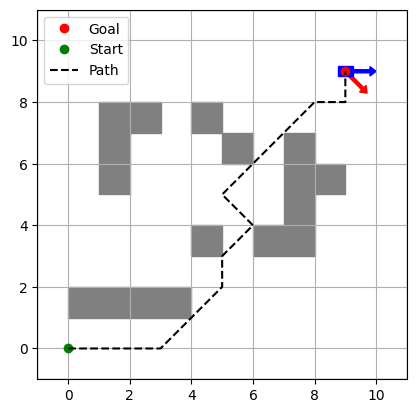

In [13]:
# Render environment for visual display
state = env.reset()
done = False
while not done:
    action = agent.choose_action(state)
    next_state, reward, done, _ = env.step(action)
    env.render()
    state = next_state
env.close()